In [63]:
# Import libraries and set desired options
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [35]:
# Read the training and test data sets
Emp = pd.read_excel(r"C:\HSCI846\Regression\Employees.xlsx")
Exp = pd.read_excel(r"C:\HSCI846\Regression\Exposures.xlsx")
Eval = pd.read_excel(r"C:\HSCI846\Regression\Evaluation.xlsx")

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Employees’ contains all the relevant employee data:
Employee = Unique employee identifier
JobCategory = A numerical code (1-4) for job category
Sex = M/F
Shift = Employee’s work shift (AM = morning; PM = afternoon)
Status = Part-time (PT) or full-time (FT)
Age = Employee’s age (years) at time of biomarker sample collection
YearsExperience = Number of years that the employee has worked at the company
StartAge = Employee’s age (years) at the start of employment

‘Exposures’ contains all the relevant exposure and PPE data:
Employee = Unique employee identifier
PPE = Type of personal protective equipment used on the day of biomarker collection: None = No PPE worn; Resp = Respirator; Mask = Face Mask
UrineConcentration = The concentration of the toxicant in a urine sample collected immediately at the end of the work shift.


After importing, use the shape, head, isnull procedure to get a description of the variables in each

In [43]:
datasets = [("Exp", Exp), ("Emp", Emp), ("Eval", Eval)]

for dataset_name, dataset in datasets:
    print(f"Dataset: {dataset_name}, Shape: {dataset.shape}")
    missing_values = dataset.isnull().sum()
    print(f"Missing values in {dataset_name}:", missing_values)

Dataset: Exp, Shape: (849, 3)
Missing values in Exp: Employee                0
PPE                   201
UrineConcentration      0
dtype: int64
Dataset: Emp, Shape: (849, 8)
Missing values in Emp: Employee           0
JobCategory        0
Sex                0
Shift              0
Status             0
Age                0
YearsExperience    0
StartAge           0
dtype: int64
Dataset: Eval, Shape: (150, 10)
Missing values in Eval: Employee               0
PPE                   44
UrineConcentration     0
JobCategory            0
Sex                    0
Shift                  0
Status                 0
Age                    0
YearsExperience        0
StartAge               0
dtype: int64


Now sort both the Employees and Exposures data sets by the variable Employee and merge the files together by that variable. Call the new, merged dataset COMBINED:

In [46]:
# Sort 'employees' DataFrame by the 'employee' column
employees_sorted = Emp.sort_values(by='Employee')

# Sort 'exposures' DataFrame by the 'employee' column
exposures_sorted = Exp.sort_values(by='Employee')

# Merge sorted DataFrames on the 'employee' column
combined = pd.merge(employees_sorted, exposures_sorted, on='Employee')

# Print the combined DataFrame
print(combined)

     Employee  JobCategory Sex Shift Status  Age  YearsExperience  StartAge  \
0           1            1   F    AM     FT   42               16        26   
1           2            3   M    AM     FT   57               33        24   
2           3            1   F    AM     FT   52               24        28   
3           4            4   M    AM     FT   55               31        24   
4           5            1   M    PM     FT   52               26        26   
..        ...          ...  ..   ...    ...  ...              ...       ...   
844       846            4   F    PM     FT   53               25        28   
845       847            3   F    PM     PT   38               15        23   
846       848            2   F    PM     FT   48               25        23   
847       849            3   M    PM     FT   57               32        25   
848       850            2   M    PM     FT   57               33        24   

      PPE  UrineConcentration  
0    Resp          

Now run SciPy on the Concentration variable in the COMBINED dataset to generate a QQ plot.

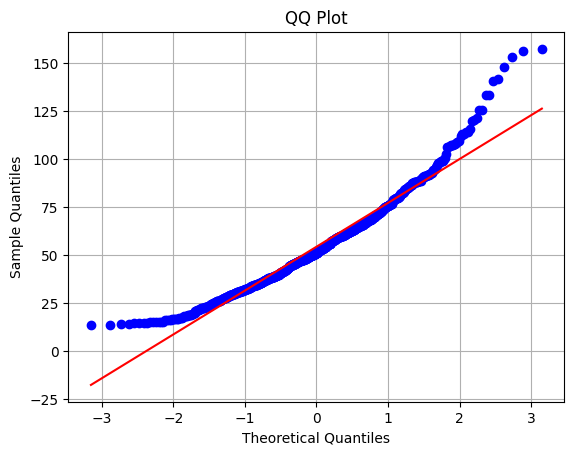

In [53]:
import matplotlib.pyplot as plt
from scipy import stats

# Create the QQ plot
stats.probplot(combined['UrineConcentration'], dist="norm", plot=plt)
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

As you can see the QQplot is not normally distributed, lets apply the logarthemic scale and check

Next, log-transform the UrineConcentration variable, and call the log-transformed variable Log_Concentration.

In [56]:
combined['log_Urine'] = np.log(combined['UrineConcentration'])

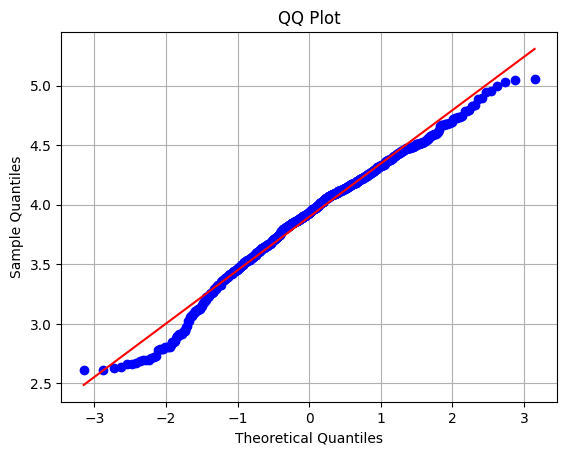

In [57]:
stats.probplot(combined['log_Urine'], dist="norm", plot=plt)
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Now you see that the QQplot is log approximately normally distributed

For the continuous variables (Age, YearsExperience, StartAge), you might want to use CORR and create correlation matrices 

In [59]:

correlation_matrix = combined[['Age', 'YearsExperience', 'StartAge','UrineConcentration']].corr()

# Print the correlation matrix
print(correlation_matrix)


                         Age  YearsExperience  StartAge  UrineConcentration
Age                 1.000000         0.965357  0.009460           -0.091481
YearsExperience     0.965357         1.000000 -0.251790           -0.102345
StartAge            0.009460        -0.251790  1.000000            0.052911
UrineConcentration -0.091481        -0.102345  0.052911            1.000000


UrineConcentration  and Age have a weak negative correlation.
UrineConcentration  and YearsExperience have a weak negative correlation.
UrineConcentration and StartAge have a weak positive correlation.

we may want to estimate a worker’s exposure to this toxicant without the need for collecting urine samples and analyzing them – it would be useful if we could approximate exposure based on information that is more easily collected such as job category, shift, sex, use of PPE, etc. Let’s start by creating dummy variables for our categorical variables: JobCategory, Shift, Status, Sex, and PPE.
a. Recall that when you create dummy variables you need one fewer variable than there are categories. For example, since there are three PPE categories (none, mask, respirator) you would need two dummy variables to describe PPE. The category that does not have a dummy variable becomes the reference category (i.e., the category indicated when all dummy variables = 0). In this case, we will create dummy variables for “Resp” and “Mask,” thereby making “None” the reference category:

In [85]:
dummy_df = pd.get_dummies(combined, columns=['JobCategory', 'Shift', 'Status', 'Sex', 'PPE'], drop_first=True)

Setting drop_first=True will drop the first level of each categorical variable, resulting in (n-1) dummy variables for each categorical variable instead of n dummy variables. This approach helps avoid multicollinearity issues in regression models.

In [86]:
dummy_df = dummy_df.astype(int)

In [87]:
dummy_df.head

<bound method NDFrame.head of      Employee  Age  YearsExperience  StartAge  UrineConcentration  log_Urine  \
0           1   42               16        26                  57          4   
1           2   57               33        24                  32          3   
2           3   52               24        28                  88          4   
3           4   55               31        24                  69          4   
4           5   52               26        26                  76          4   
..        ...  ...              ...       ...                 ...        ...   
844       846   53               25        28                  81          4   
845       847   38               15        23                  49          3   
846       848   48               25        23                  25          3   
847       849   57               32        25                  47          3   
848       850   57               33        24                  33          3   

     JobC

In [88]:
dummy_df.columns

Index(['Employee', 'Age', 'YearsExperience', 'StartAge', 'UrineConcentration',
       'log_Urine', 'JobCategory_2', 'JobCategory_3', 'JobCategory_4',
       'Shift_PM', 'Status_PT', 'Sex_M', 'PPE_Resp'],
      dtype='object')

In [94]:
# Define the independent variables
X = dummy_df[[ 'Age', 'YearsExperience', 'StartAge',
    'JobCategory_2', 'JobCategory_3', 'JobCategory_4',
       'Shift_PM', 'Status_PT', 'Sex_M', 'PPE_Resp',
]]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = dummy_df['log_Urine']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Urine   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     28.13
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           7.29e-43
Time:                        23:22:55   Log-Likelihood:                -631.47
No. Observations:                 849   AIC:                             1283.
Df Residuals:                     839   BIC:                             1330.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.7513      0.279     

Now that our model is ready lets work on the independent dataset

Create dummy variables in the evaluation dataset

In [90]:
Eval_dummy = pd.get_dummies(Eval, columns=['JobCategory', 'Shift', 'Status', 'Sex', 'PPE'], drop_first=True)

In [92]:
Eval_dummy= Eval_dummy.astype(int)

In [93]:
Eval_dummy.dtypes

Employee              int32
UrineConcentration    int32
Age                   int32
YearsExperience       int32
StartAge              int32
JobCategory_2         int32
JobCategory_3         int32
JobCategory_4         int32
Shift_PM              int32
Status_PT             int32
Sex_M                 int32
PPE_Resp              int32
dtype: object

In [95]:
Eval_dummy.columns

Index(['Employee', 'UrineConcentration', 'Age', 'YearsExperience', 'StartAge',
       'JobCategory_2', 'JobCategory_3', 'JobCategory_4', 'Shift_PM',
       'Status_PT', 'Sex_M', 'PPE_Resp'],
      dtype='object')

In [96]:
# Add constant to independent variables
dummy_variables= Eval_dummy[['Age', 'YearsExperience', 'StartAge',
       'JobCategory_2', 'JobCategory_3', 'JobCategory_4', 'Shift_PM',
       'Status_PT', 'Sex_M', 'PPE_Resp']]
X_new = sm.add_constant(dummy_variables)

# Predict log-transformed urine concentrations using regression parameters
Eval_dummy['log_predicted'] = model.predict(X_new)


     Employee  UrineConcentration  Age  YearsExperience  StartAge  \
0         851                  45   57               31        26   
1         852                  19   43               22        21   
2         853                  73   63               40        23   
3         854                  60   45               20        25   
4         855                  30   48               22        26   
..        ...                 ...  ...              ...       ...   
145       996                  51   54               30        24   
146       997                  60   51               24        27   
147       998                  16   51               28        23   
148       999                  40   36               11        25   
149      1000                  17   46               19        27   

     JobCategory_2  JobCategory_3  JobCategory_4  Shift_PM  Status_PT  Sex_M  \
0                0              0              0         0          0      1   
1          

In [102]:
Eval_dummy.columns

Index(['Employee', 'UrineConcentration', 'Age', 'YearsExperience', 'StartAge',
       'JobCategory_2', 'JobCategory_3', 'JobCategory_4', 'Shift_PM',
       'Status_PT', 'Sex_M', 'PPE_Resp', 'log_predicted'],
      dtype='object')

In [105]:
Eval_dummy['predicted'] = np.exp(Eval_dummy['log_predicted'])

In [106]:
Eval_dummy[['UrineConcentration', 'predicted']]

,UrineConcentration,predicted
0,45,35.799500
1,19,21.749041
2,73,26.791908
3,60,46.443583
4,30,19.729338
...,...,...
145,51,39.614408
146,60,24.323492
147,16,22.857779
148,40,28.297827


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


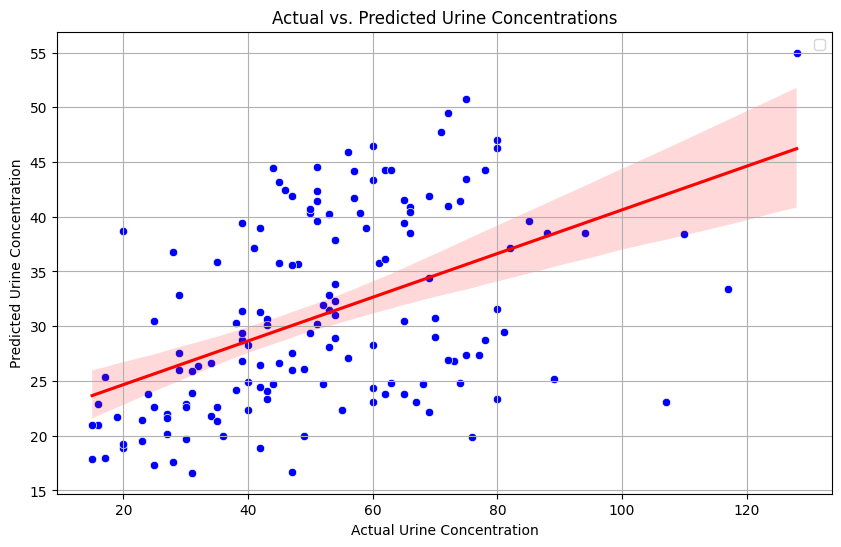

In [115]:

# Plot UrineConcentration against Predicted
plt.figure(figsize=(10, 6))

sns.scatterplot(data=Eval_dummy, x='UrineConcentration', y=predicted, color='blue',) 

sns.regplot(data=Eval_dummy, x='UrineConcentration', y='predicted', scatter=False, color='red')

# Add labels and title
plt.title('Actual vs. Predicted Urine Concentrations')
plt.xlabel('Actual Urine Concentration')
plt.ylabel('Predicted Urine Concentration')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
